# Learning Spatial Relationships with MISTy


### Import generic packages

In [21]:
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9
import liana as li

### Import helper functions and Pre-defined single view models 

In [22]:
from liana.method import MistyData, genericMistyData, lrMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

### Load and normalize data

In [23]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
adata_10 = sc.read(folder+'adata_fov_10_npod_annotation_filtered.h5ad')
adata_12 = sc.read(folder+'adata_fov_12_npod_annotation_filtered.h5ad')
adata_10,adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
     varm: 'PCs'
     layers: 'cou

In [24]:
adata_10.layers['counts'] = adata_10.X.copy()
sc.pp.normalize_total(adata_10, target_sum=1e4)
sc.pp.log1p(adata_10)

adata_12.layers['counts'] = adata_12.X.copy()
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)

### Functional analysis

#### pathway activity

In [25]:
# obtain genesets
progeny = dc.get_progeny(organism='human', top=500)

In [26]:
# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata_10,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata_12,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 4423 samples and 979 targets for 14 sources.


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Running mlm on mat with 5208 samples and 979 targets for 14 sources.


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


In [27]:
# extract progeny activities as an AnnData object
acts_progeny_10 = li.ut.obsm_to_adata(adata_10, 'mlm_estimate')
acts_progeny_12 = li.ut.obsm_to_adata(adata_12, 'mlm_estimate')

In [28]:
acts_progeny_10.var_names

Index(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype='object')

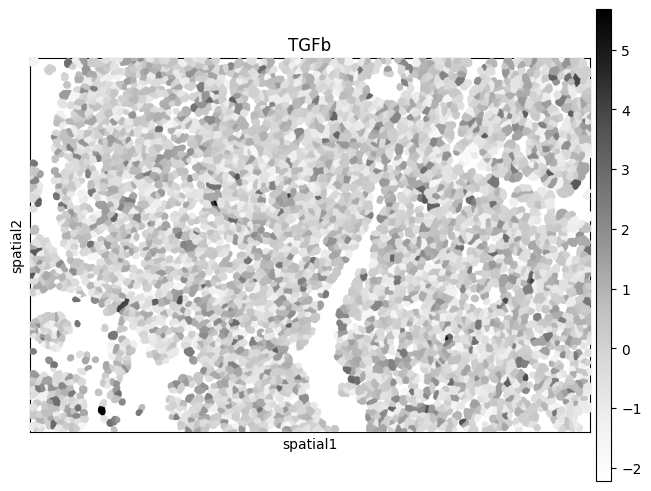

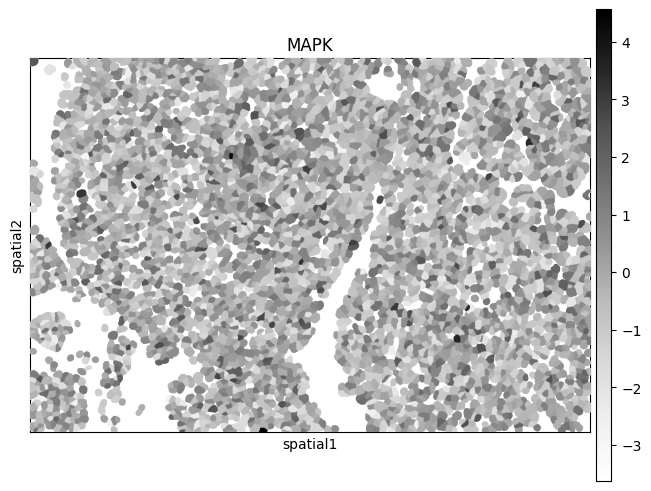

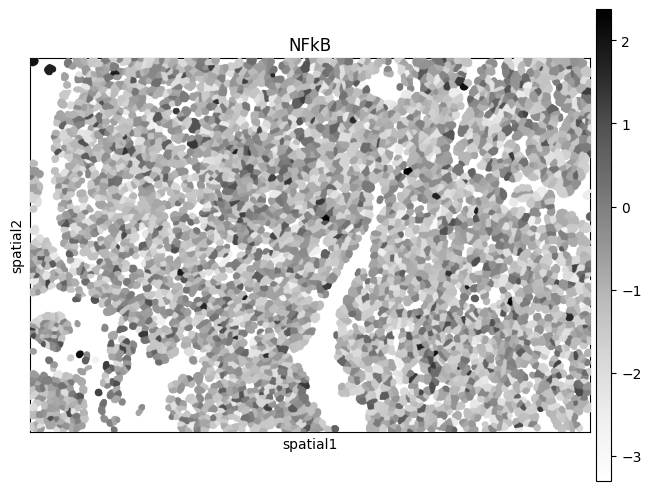

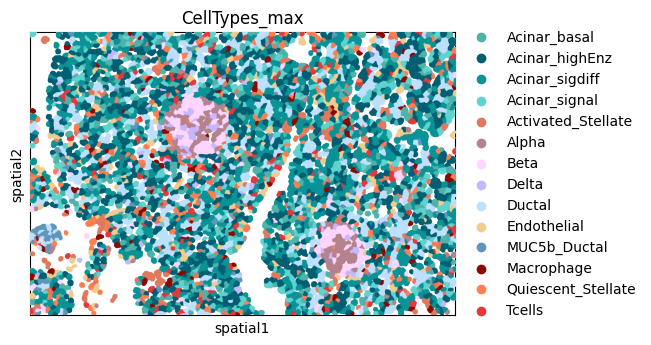

In [50]:
# Check how the pathway activities look like
markers = ['TGFb','MAPK','NFkB','CellTypes_max']
for m in markers:
    sq.pl.spatial_segment(acts_progeny_10,color=m,ncols=1,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

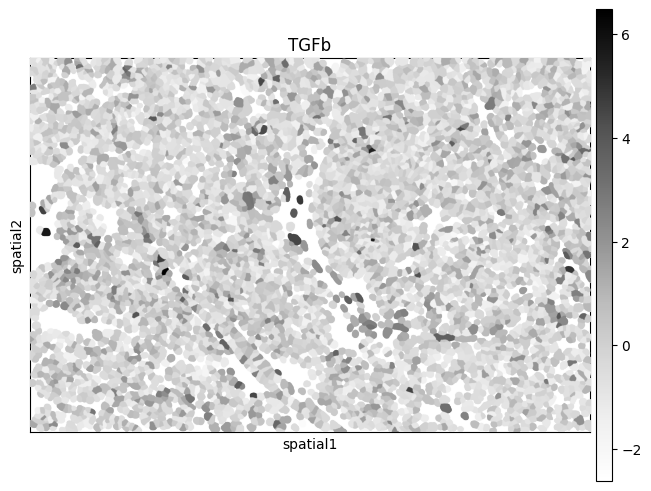

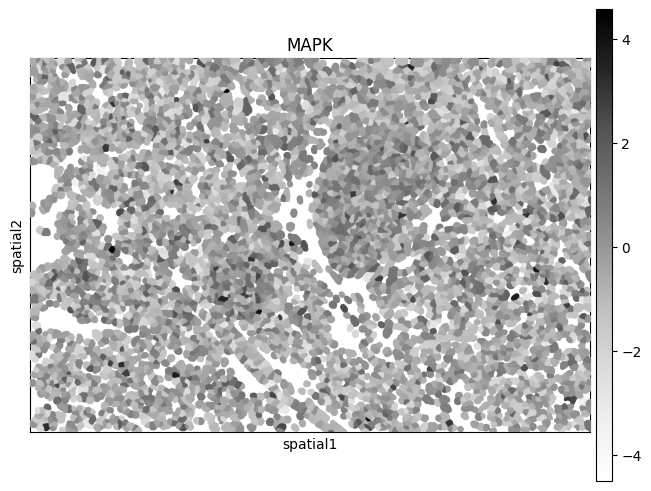

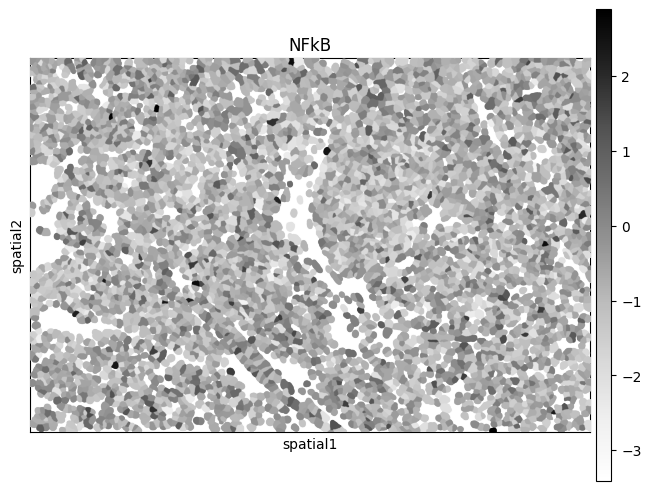

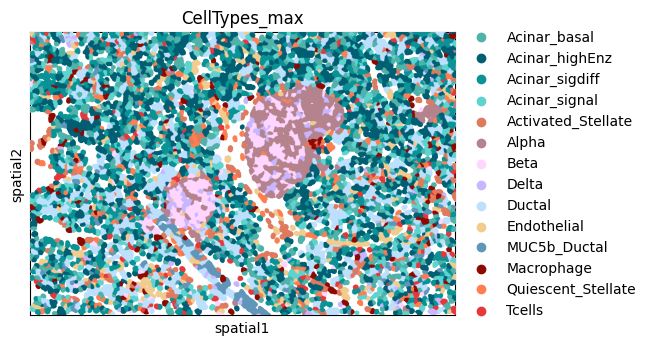

In [52]:
markers = ['TGFb','MAPK','NFkB','CellTypes_max']
for m in markers:
    sq.pl.spatial_segment(acts_progeny_12,color=m,ncols=1,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

In [ ]:
sq.pl.spatial_segment(acts_progeny_10,color=['Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],ncols=7,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

sq.pl.spatial_segment(acts_progeny_12,color=['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],ncols=7,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

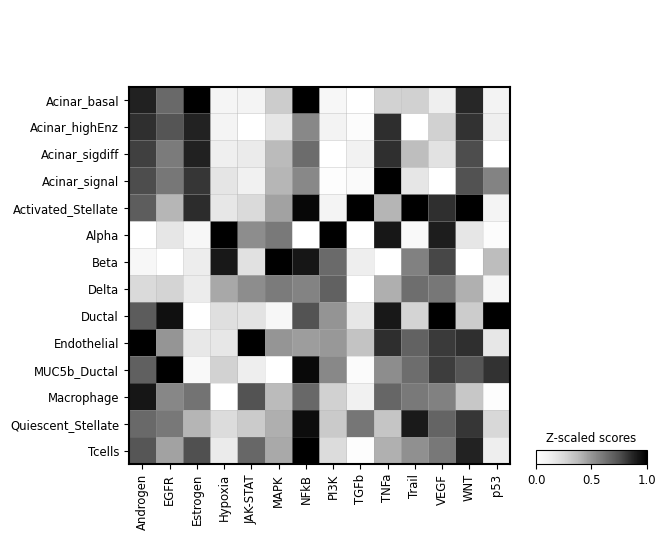

In [31]:
sc.pl.matrixplot(acts_progeny_12, var_names=acts_progeny_12.var_names, groupby='CellTypes_max', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

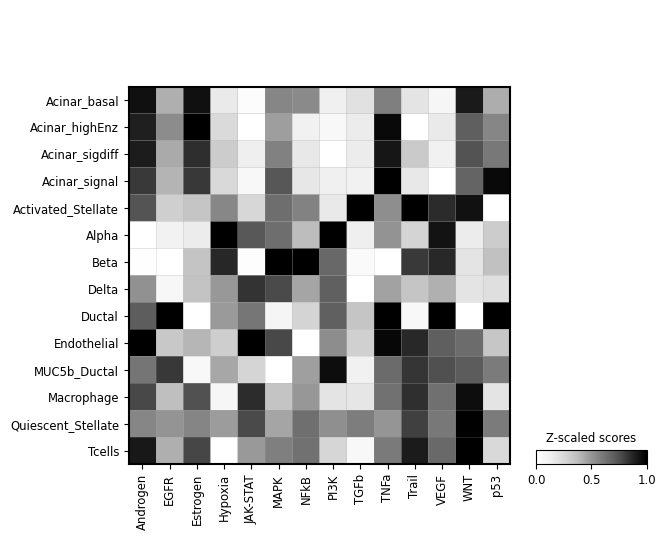

In [32]:
sc.pl.matrixplot(acts_progeny_10, var_names=acts_progeny_10.var_names, groupby='CellTypes_max', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

#### TF activity inference

In [33]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [34]:
dc.run_ulm(
    mat=adata_10,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

dc.run_ulm(
    mat=adata_12,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 4423 samples and 979 targets for 469 sources.


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Running ulm on mat with 5208 samples and 979 targets for 469 sources.


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


In [35]:
acts_10 = dc.get_acts(adata_10, obsm_key='ulm_estimate')
acts_12 = dc.get_acts(adata_12, obsm_key='ulm_estimate')

In [36]:
acts_10.var_names

Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID4B', 'ARNT',
       'ARX',
       ...
       'ZKSCAN7', 'ZMYND8', 'ZNF148', 'ZNF300', 'ZNF354C', 'ZNF362', 'ZNF382',
       'ZNF384', 'ZNF699', 'ZNF91'],
      dtype='object', length=469)

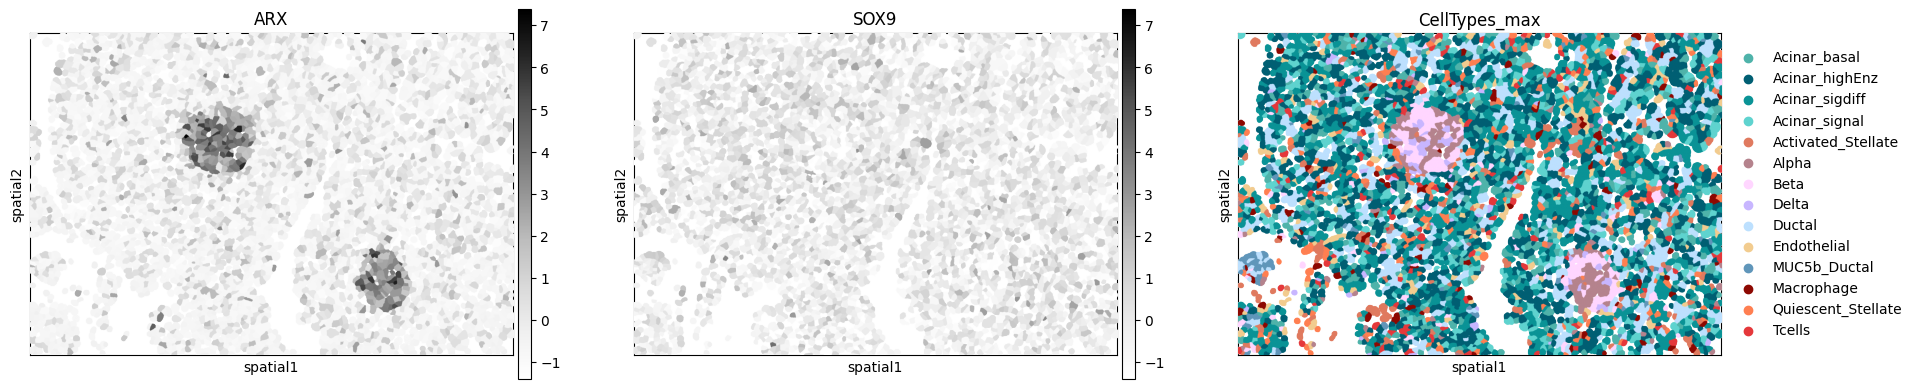

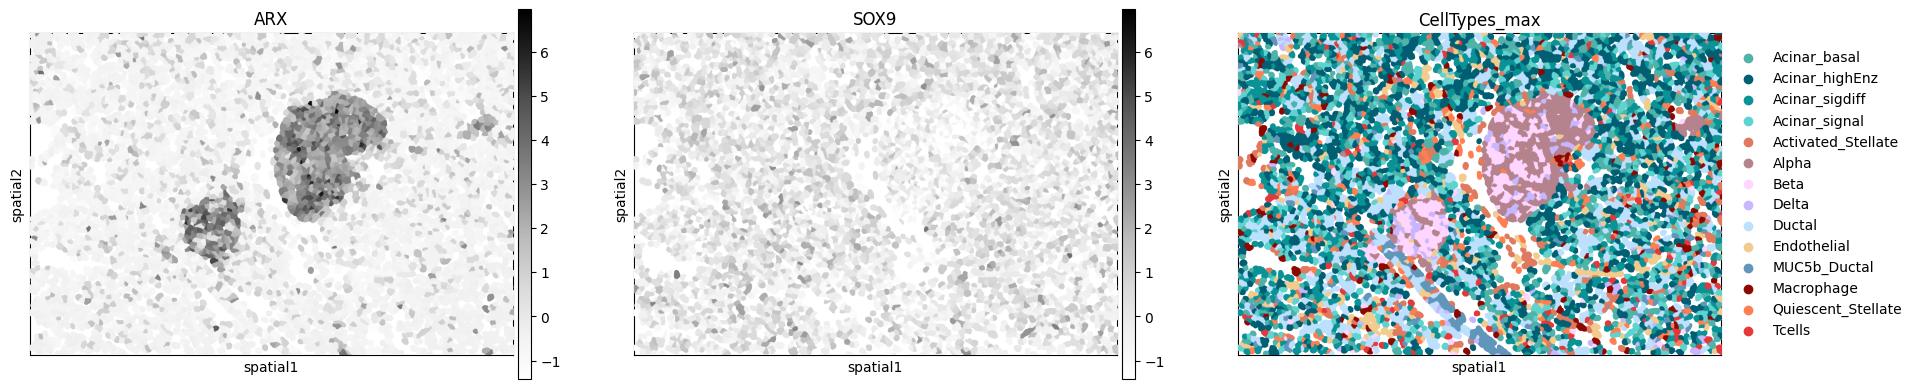

In [37]:
# Check how the TF activities look like
sq.pl.spatial_segment(acts_10,color=['ARX', 'SOX9', 'CellTypes_max'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

sq.pl.spatial_segment(acts_12,color=['ARX', 'SOX9', 'CellTypes_max'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

In [38]:
df_10 = dc.rank_sources_groups(acts_10, groupby='CellTypes_max', reference='rest', method='t-test_overestim_var')
df_12 = dc.rank_sources_groups(acts_12, groupby='CellTypes_max', reference='rest', method='t-test_overestim_var')

In [39]:
n_markers = 2
source_markers_10 = df_10.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers_12 = df_12.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers_10, source_markers_12

({'Acinar_basal': ['ZBTB33', 'NR0B2'],
  'Acinar_highEnz': ['MZF1', 'KLF15'],
  'Acinar_sigdiff': ['KLF15', 'MTF1'],
  'Acinar_signal': ['SOX6', 'ING4'],
  'Activated_Stellate': ['SKIL', 'SMAD3'],
  'Alpha': ['MAFA', 'ARX'],
  'Beta': ['ZGLP1', 'ISL1'],
  'Delta': ['MAFA', 'ISL1'],
  'Ductal': ['MYBL2', 'SP4'],
  'Endothelial': ['CIITA', 'ERG'],
  'MUC5b_Ductal': ['SALL4', 'NFYB'],
  'Macrophage': ['RFX5', 'RFXANK'],
  'Quiescent_Stellate': ['SKIL', 'SMAD3'],
  'Tcells': ['STAT4', 'TBX21']},
 {'Acinar_basal': ['NR0B2', 'BHLHE41'],
  'Acinar_highEnz': ['MZF1', 'ZNF362'],
  'Acinar_sigdiff': ['KLF15', 'HTATIP2'],
  'Acinar_signal': ['PITX2', 'THRB'],
  'Activated_Stellate': ['SMAD3', 'SKIL'],
  'Alpha': ['ARX', 'ONECUT1'],
  'Beta': ['MAFA', 'ZGLP1'],
  'Delta': ['ARX', 'ISL1'],
  'Ductal': ['KLF8', 'SP4'],
  'Endothelial': ['ERG', 'GATA2'],
  'MUC5b_Ductal': ['HSF2', 'TAF1'],
  'Macrophage': ['RFXAP', 'RFXANK'],
  'Quiescent_Stellate': ['SKIL', 'SMAD3'],
  'Tcells': ['TBX21', 'NR0B2']})

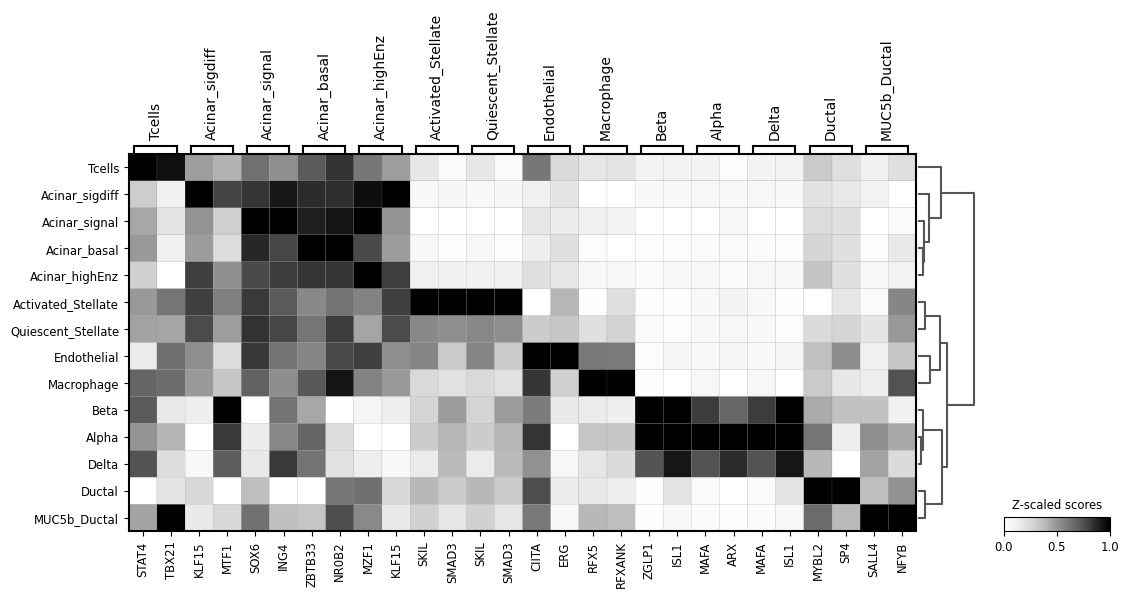

In [40]:
sc.pl.matrixplot(acts_10, source_markers_10, 'CellTypes_max', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

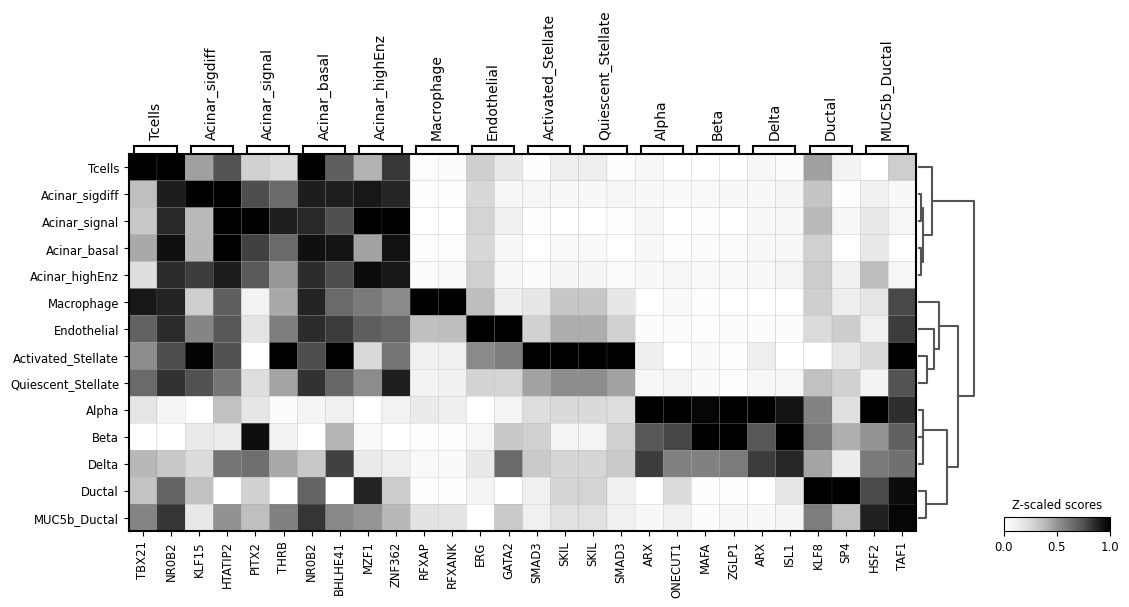

In [41]:
sc.pl.matrixplot(acts_12, source_markers_12, 'CellTypes_max', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys')

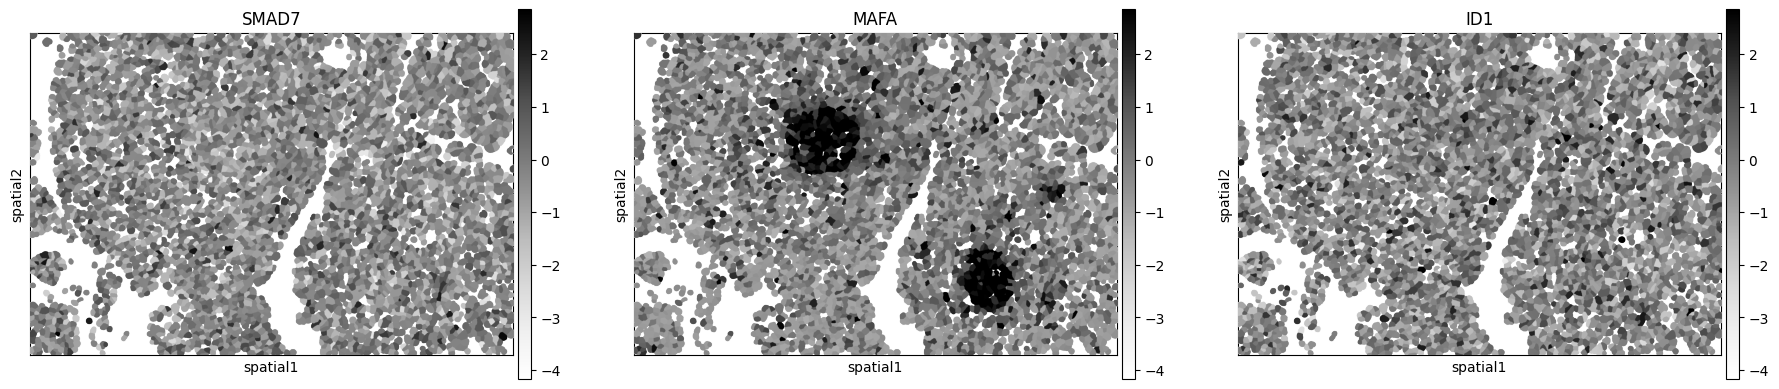

In [68]:
sq.pl.spatial_segment(acts_10,color=['SMAD7','MAFA','ID1'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

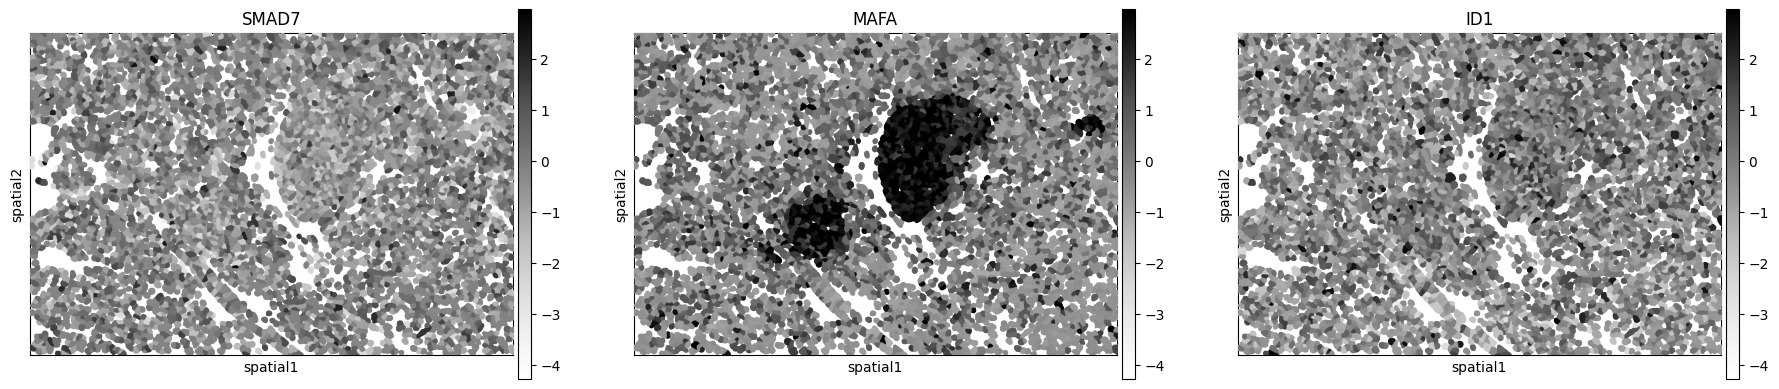

In [69]:
sq.pl.spatial_segment(acts_12,color=['SMAD7','MAFA','ID1'],ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

### Functional enrichment of biological terms

In [48]:
msigdb = dc.get_resource('MSigDB')
msigdb

Retrying (Retry(total=2, connect=None, read=None, redirect=5, status=None)) after connection broken by 'SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1133)'))': /resources?format=json
56.5kB [00:00, 5.07MB/s]
528MB [00:07, 70.1MB/s] 


genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

In [53]:
msigdb['collection'].cat.categories

Index(['biocarta_pathways', 'cancer_gene_neighborhoods', 'cancer_modules',
       'cell_type_signatures', 'chemical_and_genetic_perturbations',
       'go_biological_process', 'go_cellular_component',
       'go_molecular_function', 'hallmark', 'human_phenotype_ontology',
       'immunesigdb', 'kegg_pathways', 'mirna_targets_legacy',
       'mirna_targets_mirdb', 'oncogenic_signatures', 'pid_pathways',
       'positional', 'reactome_pathways', 'tf_targets_gtrf',
       'tf_targets_legacy', 'vaccine_response', 'wikipathways'],
      dtype='string')

In [54]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

/tmp/ipykernel_2007594/2098377670.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['IL2_STAT5_SIGNALING', 'COAGULATION', 'HYPOXIA', 'TNFA_SIGNALING_VIA_NFKB', 'COMPLEMENT', 'HYPOXIA', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'GLYCOLYSIS', 'APOPTOSIS', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'EPITHELIAL_MESENCHYMAL_TRANSITION', 'IL2_STAT5_SIGNALING', 'TNFA_SIGNALING_VIA_NFKB', 'TNFA_SIGNALING_VIA_NFKB', 'PROTEIN_SECRETION', 'ADIPOGENESIS', 'BILE_ACID_METABOLISM', 'INFLAMMATORY_RESPONSE', 'INFLAMMATORY_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'UNFOLDED_PROTEIN_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB', 'IL2_STAT5_SIGNALING', 'P53_PATHWAY', 'TNFA_SIGNALING_VIA_NFKB', 'TGF_BETA_SIGNALING', 'KRAS_SIGNALING_UP', 'UV_RESPONSE_UP', 'APOPTOSIS', 'TNFA_SIGNALING_VIA_NFKB', 'APOPTOSIS', 'ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE', 'INTERFERON_ALPHA_RESPONSE', 'TNFA_SIGNALING_VIA_NFKB',

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [55]:
dc.run_ora(
    mat=adata_10,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
    use_raw=False
)

# Store in a different key
adata_10.obsm['msigdb_ora_estimate'] = adata_10.obsm['ora_estimate'].copy()
adata_10.obsm['msigdb_ora_pvals'] = adata_10.obsm['ora_pvals'].copy()

dc.run_ora(
    mat=adata_12,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
    use_raw=False
)

# Store in a different key
adata_12.obsm['msigdb_ora_estimate'] = adata_12.obsm['ora_estimate'].copy()
adata_12.obsm['msigdb_ora_pvals'] = adata_12.obsm['ora_pvals'].copy()


Running ora on mat with 4423 samples and 979 targets for 46 sources.


100%|██████████| 4423/4423 [00:01<00:00, 2623.54it/s]


Running ora on mat with 5208 samples and 979 targets for 46 sources.


100%|██████████| 5208/5208 [00:01<00:00, 3324.89it/s]


In [57]:
import numpy as np
acts_bt_10 = dc.get_acts(adata_10, obsm_key='msigdb_ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v_10 = acts_bt_10.X.ravel()
max_e_10 = np.nanmax(acts_v_10[np.isfinite(acts_v_10)])
acts_bt_10.X[~np.isfinite(acts_bt_10.X)] = max_e_10

acts_bt_12 = dc.get_acts(adata_12, obsm_key='msigdb_ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v_12 = acts_bt_12.X.ravel()
max_e_12 = np.nanmax(acts_v_12[np.isfinite(acts_v_12)])
acts_bt_12.X[~np.isfinite(acts_bt_12.X)] = max_e_12

acts_bt_10, acts_bt_12

(AnnData object with n_obs × n_vars = 4423 × 46
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'dendrogram_CellTypes_max'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov', 'mlm_estimate', 'mlm_pvals', 'ulm_estimate', 'ulm_pvals', 'ora_estimate', 'ora_pvals', 'msigdb_ora_estimate', 'msigdb_ora_pvals',
 AnnData object with n_obs

In [58]:
bt_10 = dc.rank_sources_groups(acts_bt_10, groupby='CellTypes_max', reference='rest', method='t-test_overestim_var')
bt_10

group reference                      names  statistic  meanchange  \
0    Acinar_basal      rest             MYC_TARGETS_V1   3.281146    0.535852   
1    Acinar_basal      rest  UNFOLDED_PROTEIN_RESPONSE   2.604240    0.262877   
2    Acinar_basal      rest    ESTROGEN_RESPONSE_EARLY   2.007510    0.322750   
3    Acinar_basal      rest           MTORC1_SIGNALING   1.692669    0.202901   
4    Acinar_basal      rest    IL6_JAK_STAT3_SIGNALING   1.465860    0.253134   
..            ...       ...                        ...        ...         ...   
639        Tcells      rest        PANCREAS_BETA_CELLS  -1.847076   -0.406266   
640        Tcells      rest                P53_PATHWAY  -2.096556   -0.452565   
641        Tcells      rest                  APOPTOSIS  -2.227959   -0.669780   
642        Tcells      rest      XENOBIOTIC_METABOLISM  -2.378015   -0.431727   
643        Tcells      rest                 MYOGENESIS  -2.716993   -0.712347   

        pvals  pvals_adj  
0    0.001083   0.005534  
1    0.009396   0.028813  
2    0.045065   0.109105  
3    0.090946   0.174313  
4    0.143115   0.219443  
..        ...        ...  
639  0.066416   0.413535  
640  0.037072   0.284222  
641  0.026827   0.246811  
642  0.018183   0.246811  
643  0.007067   0.162539  

[644 rows x 7 columns]

In [59]:
bt_12 = dc.rank_sources_groups(acts_bt_12, groupby='CellTypes_max', reference='rest', method='t-test_overestim_var')
bt_12

group reference                            names  statistic  \
0    Acinar_basal      rest          IL6_JAK_STAT3_SIGNALING   3.770851   
1    Acinar_basal      rest        UNFOLDED_PROTEIN_RESPONSE   3.475330   
2    Acinar_basal      rest                KRAS_SIGNALING_DN   2.788857   
3    Acinar_basal      rest                   MYC_TARGETS_V1   2.454255   
4    Acinar_basal      rest                 MTORC1_SIGNALING   2.371387   
..            ...       ...                              ...        ...   
639        Tcells      rest  REACTIVE_OXYGEN_SPECIES_PATHWAY  -2.315102   
640        Tcells      rest             BILE_ACID_METABOLISM  -2.915897   
641        Tcells      rest                       MYOGENESIS  -3.095656   
642        Tcells      rest                       COMPLEMENT  -3.352027   
643        Tcells      rest              PANCREAS_BETA_CELLS  -3.995921   

     meanchange     pvals  pvals_adj  
0      0.507644  0.000171   0.000715  
1      0.294368  0.000530   0.001874  
2      0.201342  0.005378   0.015461  
3      0.334000  0.014266   0.032275  
4      0.233107  0.017885   0.032909  
..          ...       ...        ...  
639   -0.369727  0.021621   0.124318  
640   -0.430142  0.004077   0.031254  
641   -0.984398  0.002266   0.020844  
642   -0.773002  0.000969   0.011142  
643   -1.174940  0.000108   0.002476  

[644 rows x 7 columns]

In [65]:
n_top = 2
term_markers_10 = bt_10.groupby('group').head(n_top).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
term_markers_12 = bt_12.groupby('group').head(n_top).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

term_markers_10, term_markers_12 

({'Acinar_basal': ['MYC_TARGETS_V1', 'UNFOLDED_PROTEIN_RESPONSE'],
  'Acinar_highEnz': ['MYC_TARGETS_V1', 'ESTROGEN_RESPONSE_EARLY'],
  'Acinar_sigdiff': ['XENOBIOTIC_METABOLISM', 'G2M_CHECKPOINT'],
  'Acinar_signal': ['MTORC1_SIGNALING', 'MYC_TARGETS_V1'],
  'Activated_Stellate': ['MYOGENESIS', 'EPITHELIAL_MESENCHYMAL_TRANSITION'],
  'Alpha': ['PANCREAS_BETA_CELLS', 'BILE_ACID_METABOLISM'],
  'Beta': ['PANCREAS_BETA_CELLS', 'BILE_ACID_METABOLISM'],
  'Delta': ['PANCREAS_BETA_CELLS', 'COAGULATION'],
  'Ductal': ['APOPTOSIS', 'CHOLESTEROL_HOMEOSTASIS'],
  'Endothelial': ['COAGULATION', 'INTERFERON_GAMMA_RESPONSE'],
  'MUC5b_Ductal': ['INTERFERON_ALPHA_RESPONSE', 'IL2_STAT5_SIGNALING'],
  'Macrophage': ['ALLOGRAFT_REJECTION', 'INTERFERON_ALPHA_RESPONSE'],
  'Quiescent_Stellate': ['MYOGENESIS', 'EPITHELIAL_MESENCHYMAL_TRANSITION'],
  'Tcells': ['ALLOGRAFT_REJECTION', 'INTERFERON_GAMMA_RESPONSE']},
 {'Acinar_basal': ['IL6_JAK_STAT3_SIGNALING', 'UNFOLDED_PROTEIN_RESPONSE'],
  'Acinar_highEn

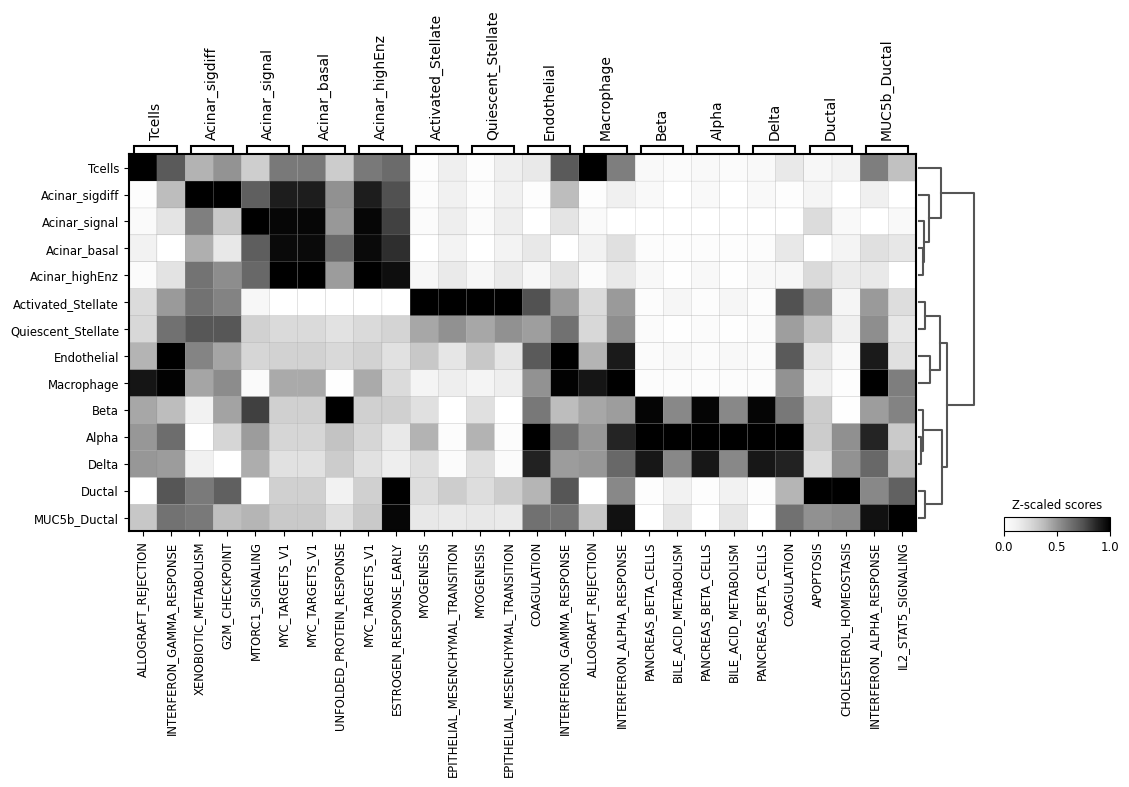

In [66]:
sc.pl.matrixplot(acts_bt_10, term_markers_10, 'CellTypes_max', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys', swap_axes=False)


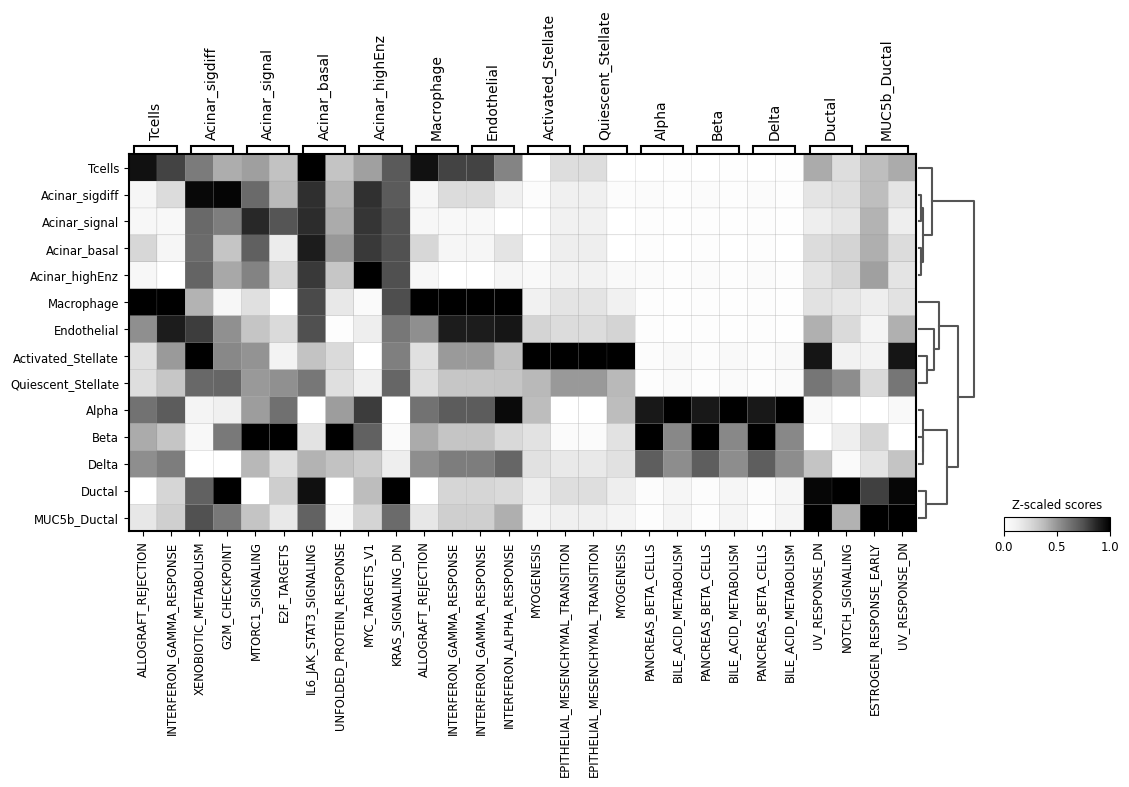

In [67]:
sc.pl.matrixplot(acts_bt_12, term_markers_12, 'CellTypes_max', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Greys', swap_axes=False)


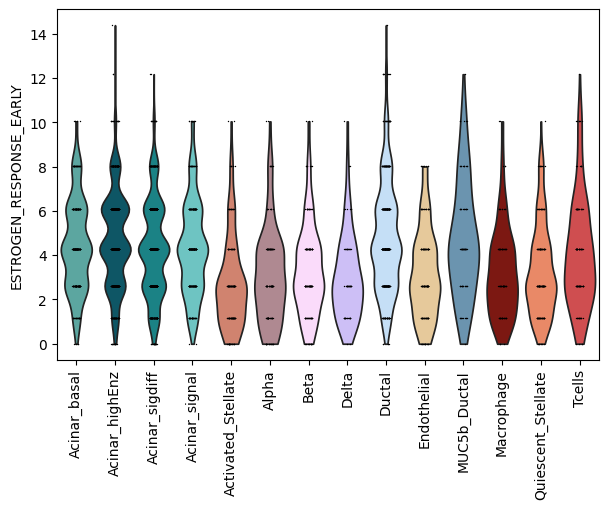

In [77]:
sc.pl.violin(
    acts_bt_10,
    keys='ESTROGEN_RESPONSE_EARLY',
    groupby='CellTypes_max',
    rotation=90
)

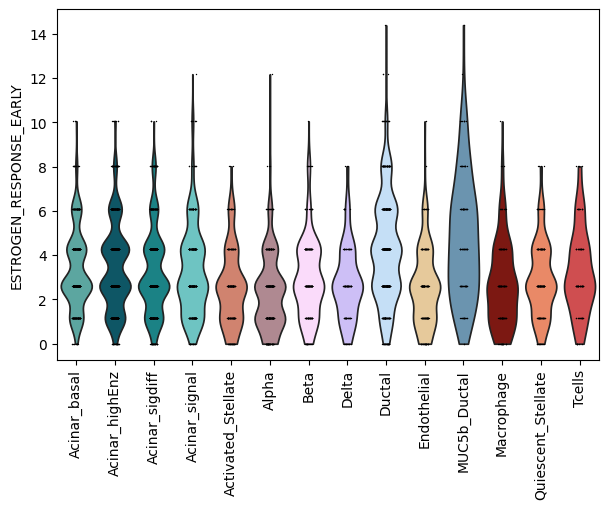

In [78]:
sc.pl.violin(
    acts_bt_12,
    keys='ESTROGEN_RESPONSE_EARLY',
    groupby='CellTypes_max',
    rotation=90
)